In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions import *

In [2]:
np.random.seed(1)

In [3]:
###--- Import spatial data ---###

### Read in the data
df = pd.read_csv('data.csv')

### Generate the arrays needed from the dataframe
data = np.array(df["bicycle.theft"]) #"original count data"
xi = np.array(df['xi'])
yi = np.array(df['yi'])
N = len(data)
coords = [(xi[i],yi[i]) for i in range(N)]

### Subsample the original data set
subsample_factor = 3
idx = subsample(N, subsample_factor, seed=42)
G = get_G(N,idx)
c = G @ data #"subsampled data"

In [4]:
###--- MCMC ---####

### Set MCMC parameters
n = 10000
beta = 0.2

### Set the likelihood and target, for sampling p(u|c)
log_target = log_poisson_target
log_likelihood = log_poisson_likelihood

In [5]:
def expected_counts_from_samples(samples, subsample=False, c_squared=False):
    us = np.array(samples)
    theta = np.exp(us @ G.T if subsample else us)
    return np.mean(theta if not c_squared else theta + theta**2, axis=0)

In [6]:
def variance_from_samples(samples):
    return expected_counts_from_samples(samples, c_squared=True) - expected_counts_from_samples(samples)**2

In [17]:
def inference_given_ell(ell, plot=False):
    #sample from prior
    K = GaussianKernel(coords, ell)
    Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
    u0 = Kc @ np.random.randn(N, )
    
    X_pcn, acc_pcn = pcn(log_likelihood, u0, c, K, G, n, beta)
    
    c_star_field = expected_counts_from_samples(X_pcn)
    c_star_points = expected_counts_from_samples(X_pcn, subsample=True)
    
    error_field = np.abs(c_star_field - data)
    mae = np.mean(error_field)
    
    c_star_variance_field = variance_from_samples(X_pcn)
    
    if plot:
        #plot_2D(data, xi, yi, title='Bike Theft Data')                   # Plot bike theft count data
        #plot_2D(c, xi[idx], yi[idx], title='Subsampled Data')      # Plot subsampled data
        plot_2D(c_star_field, xi, yi, title=f"Exp. counts, $\ell$={ell}, MAE={round(mae,3)}")#'Inferred count means at all data points')
        #plot_2D(c_star_variance_field, xi, yi, title='Inferred count vars at all data points')
        #plot_2D(c_star_points, xi[idx], yi[idx], title='Inferred count means at subsampled positions')
        #plot_2D(error_field, xi, yi, title='Error field')
    
    return mae

100%|██████████| 10000/10000 [00:03<00:00, 3217.45it/s]


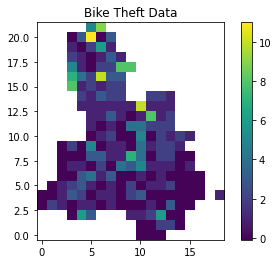

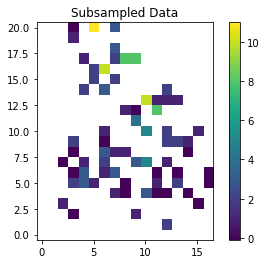

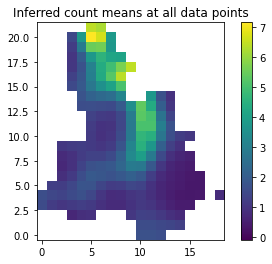

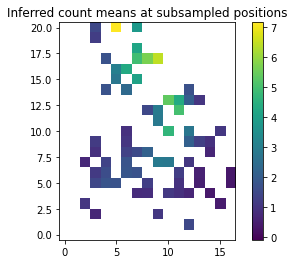

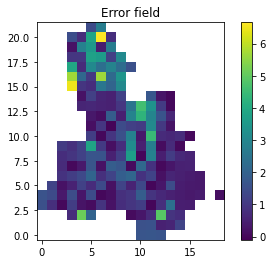

1.3431205193796787

In [12]:
inference_given_ell(2, plot=True)

100%|██████████| 10000/10000 [00:03<00:00, 3216.55it/s]


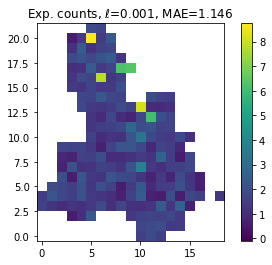

100%|██████████| 10000/10000 [00:03<00:00, 3282.95it/s]


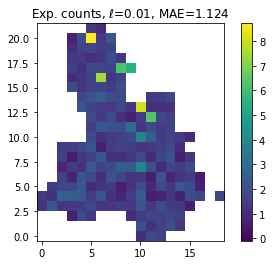

100%|██████████| 10000/10000 [00:03<00:00, 3200.43it/s]


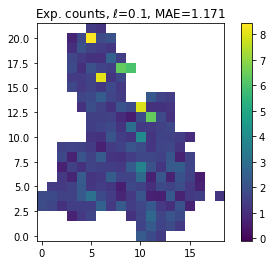

100%|██████████| 10000/10000 [00:02<00:00, 3341.01it/s]


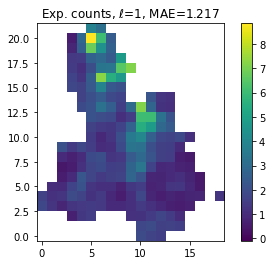

100%|██████████| 10000/10000 [00:03<00:00, 3233.17it/s]


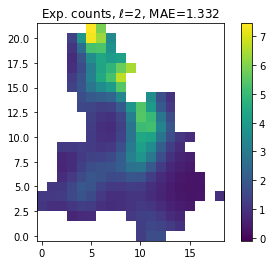

100%|██████████| 10000/10000 [00:03<00:00, 3185.41it/s]


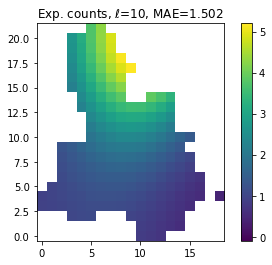

100%|██████████| 10000/10000 [00:03<00:00, 2966.26it/s]


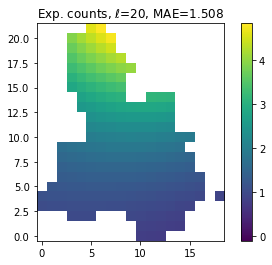

In [19]:
maes = []
for ell in [0.001, 0.01, 0.1,1, 2, 10, 20]:
    maes += [inference_given_ell(ell, plot=True)]

In [20]:
maes

[1.1455108559226357,
 1.1239184460731162,
 1.1705147208049371,
 1.216806163785982,
 1.3322606460924626,
 1.5018583368097012,
 1.5081815205529645]

In [22]:
rng = np.power(10, np.linspace(start=-4, stop=1, num=40))

In [23]:
maes2 = []
for ell in rng:
    maes2 += [inference_given_ell(ell, plot=False)]

100%|██████████| 10000/10000 [00:02<00:00, 3384.41it/s]


Text(0.5, 1.0, 'Inference error given length scale')

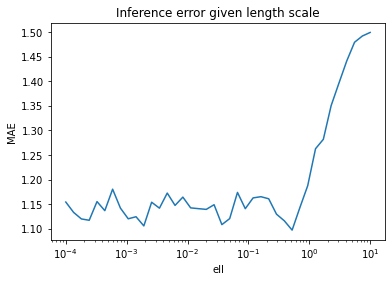

In [25]:
plt.plot(rng, maes2)
plt.xscale('log')
plt.xlabel("ell")
plt.ylabel("MAE")
plt.title("Inference error given length scale")

In [27]:
rng[np.array(maes2).argmin()]

0.5223345074266837